# Importing Libraries

In [ ]:
import pandas as pd 
import numpy as np
import os

import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objects as go

from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import ExtraTreesRegressor

from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
import pickle

In [26]:
train_folder = 'train'
test_folder = 'test'
dataset_folder = 'dataset'

# Loading Data

In [3]:
path_to_incoming_run = os.path.join(dataset_folder, 'incoming_run_data.parquet')
if not os.path.exists(path_to_incoming_run):
    print("File does not exist, creating a new one.")
    incoming_run_files = [f for f in os.listdir(train_folder) if 'incoming_run_data' in f]
    incoming_dataframes = []
    previous_run_id_list = []

    for files in incoming_run_files:
        temp_df = pd.read_parquet(os.path.join(train_folder, files))
        print(temp_df["Tool ID"].unique())

        run_id_list = temp_df["Run ID"].unique().tolist()

        if any(run_id in previous_run_id_list for run_id in run_id_list):
            print("Duplicate Run ID found in previous_run_id_list")
        
        previous_run_id_list.extend(run_id_list)
        incoming_dataframes.append(temp_df)

    incoming_df = pd.concat(incoming_dataframes, ignore_index=True)

    incoming_df.to_parquet('dataset/incoming_run_data.parquet', index=False)
else:
    print("File already exists, loading the existing one.")
    incoming_df = pd.read_parquet(path_to_incoming_run)

incoming_df

File already exists, loading the existing one.


,Tool ID,Run Start Time,Run End Time,Run ID,Process Step,Step ID,Time Stamp,Sensor Name,Sensor Value
0,d7291410-f34f-5cee-b3a1-0c60bb854423,2023-12-31 00:00:00,2023-12-31 00:12:22,630ce06e-efcd-5473-9d2a-859f43908b8f,22c8716b-1c14-525a-8c0a-0473ec7aa99e,Step_0,2023-12-31 00:00:00.000000000,Sensor_1,195.469116
1,d7291410-f34f-5cee-b3a1-0c60bb854423,2023-12-31 00:00:00,2023-12-31 00:12:22,630ce06e-efcd-5473-9d2a-859f43908b8f,22c8716b-1c14-525a-8c0a-0473ec7aa99e,Step_0,2023-12-31 00:00:01.000000002,Sensor_1,195.497040
2,d7291410-f34f-5cee-b3a1-0c60bb854423,2023-12-31 00:00:00,2023-12-31 00:12:22,630ce06e-efcd-5473-9d2a-859f43908b8f,22c8716b-1c14-525a-8c0a-0473ec7aa99e,Step_0,2023-12-31 00:00:01.999999997,Sensor_1,195.497025
3,d7291410-f34f-5cee-b3a1-0c60bb854423,2023-12-31 00:00:00,2023-12-31 00:12:22,630ce06e-efcd-5473-9d2a-859f43908b8f,22c8716b-1c14-525a-8c0a-0473ec7aa99e,Step_1,2023-12-31 00:00:03.000000000,Sensor_1,195.474823
4,d7291410-f34f-5cee-b3a1-0c60bb854423,2023-12-31 00:00:00,2023-12-31 00:12:22,630ce06e-efcd-5473-9d2a-859f43908b8f,22c8716b-1c14-525a-8c0a-0473ec7aa99e,Step_1,2023-12-31 00:00:04.000000002,Sensor_1,195.496368
...,...,...,...,...,...,...,...,...,...
82896501,a060c807-dbdb-5de3-9cd7-0c596234a3d7,2024-01-03 23:43:15,2024-01-03 23:55:50,6908f294-5178-50bc-ba5b-5293435ba574,22c8716b-1c14-525a-8c0a-0473ec7aa99e,Step_7,2024-01-03 23:51:09.000000000,Sensor_9,2.702956
82896502,a060c807-dbdb-5de3-9cd7-0c596234a3d7,2024-01-03 23:43:15,2024-01-03 23:55:50,6908f294-5178-50bc-ba5b-5293435ba574,22c8716b-1c14-525a-8c0a-0473ec7aa99e,Step_7,2024-01-03 23:51:10.000000002,Sensor_9,2.957552
82896503,a060c807-dbdb-5de3-9cd7-0c596234a3d7,2024-01-03 23:43:15,2024-01-03 23:55:50,6908f294-5178-50bc-ba5b-5293435ba574,22c8716b-1c14-525a-8c0a-0473ec7aa99e,Step_7,2024-01-03 23:51:10.999999998,Sensor_9,-0.477442
82896504,a060c807-dbdb-5de3-9cd7-0c596234a3d7,2024-01-03 23:43:15,2024-01-03 23:55:50,6908f294-5178-50bc-ba5b-5293435ba574,22c8716b-1c14-525a-8c0a-0473ec7aa99e,Step_7,2024-01-03 23:51:12.000000000,Sensor_9,-1.214340


In [4]:
path_to_run = os.path.join(dataset_folder, 'run_data.parquet')
if not os.path.exists(path_to_run):
    print("File does not exist, creating a new one.")
    run_files = [f for f in os.listdir(train_folder) if 'run_data' in f and 'incoming' not in f]
    run_dataframes = []
    previous_run_id_list = []

    for files in run_files:
        temp_df = pd.read_parquet(os.path.join(train_folder, files))
        print(temp_df["Tool ID"].unique())

        run_id_list = temp_df["Run ID"].unique().tolist()

        if any(run_id in previous_run_id_list for run_id in run_id_list):
            print("Duplicate Run ID found in previous_run_id_list")
        
        previous_run_id_list.extend(run_id_list)
        run_dataframes.append(temp_df)

    run_df = pd.concat(run_dataframes, ignore_index=True)

    run_df.to_parquet('dataset/run_data.parquet', index=False)

else:
    print("File already exists, loading the existing one.")
    run_df = pd.read_parquet(path_to_run)

run_df

File already exists, loading the existing one.


,Tool ID,Run Start Time,Run End Time,Run ID,Process Step,Consumable Life,Step ID,Time Stamp,Sensor Name,Sensor Value
0,30476bd4-f093-56c9-8cd1-23cf7f39ce5f,2024-01-01 00:00:00,2024-01-01 00:12:35,c749278a-b1a4-5062-a57e-45e4946f6b78,22c8716b-1c14-525a-8c0a-0473ec7aa99e,199.290131,Step_0,2024-01-01 00:00:00.000000000,Sensor_A,-0.024998
1,30476bd4-f093-56c9-8cd1-23cf7f39ce5f,2024-01-01 00:00:00,2024-01-01 00:12:35,c749278a-b1a4-5062-a57e-45e4946f6b78,22c8716b-1c14-525a-8c0a-0473ec7aa99e,199.290131,Step_0,2024-01-01 00:00:01.000000002,Sensor_A,0.073171
2,30476bd4-f093-56c9-8cd1-23cf7f39ce5f,2024-01-01 00:00:00,2024-01-01 00:12:35,c749278a-b1a4-5062-a57e-45e4946f6b78,22c8716b-1c14-525a-8c0a-0473ec7aa99e,199.290131,Step_1,2024-01-01 00:00:01.999999997,Sensor_A,0.070384
3,30476bd4-f093-56c9-8cd1-23cf7f39ce5f,2024-01-01 00:00:00,2024-01-01 00:12:35,c749278a-b1a4-5062-a57e-45e4946f6b78,22c8716b-1c14-525a-8c0a-0473ec7aa99e,199.290131,Step_1,2024-01-01 00:00:03.000000000,Sensor_A,0.064502
4,30476bd4-f093-56c9-8cd1-23cf7f39ce5f,2024-01-01 00:00:00,2024-01-01 00:12:35,c749278a-b1a4-5062-a57e-45e4946f6b78,22c8716b-1c14-525a-8c0a-0473ec7aa99e,199.290131,Step_1,2024-01-01 00:00:04.000000002,Sensor_A,-0.097807
...,...,...,...,...,...,...,...,...,...,...
41220745,ad28cd71-3811-543c-80a1-a440468a49d7,2024-01-04 04:38:15,2024-01-04 04:50:50,84a6fa0a-721c-576c-97f6-1f5bfe46de4a,22c8716b-1c14-525a-8c0a-0473ec7aa99e,67.854195,Step_12,2024-01-04 04:48:06.000000000,Sensor_O,775.952576
41220746,ad28cd71-3811-543c-80a1-a440468a49d7,2024-01-04 04:38:15,2024-01-04 04:50:50,84a6fa0a-721c-576c-97f6-1f5bfe46de4a,22c8716b-1c14-525a-8c0a-0473ec7aa99e,67.854195,Step_12,2024-01-04 04:48:07.000000002,Sensor_O,771.639465
41220747,ad28cd71-3811-543c-80a1-a440468a49d7,2024-01-04 04:38:15,2024-01-04 04:50:50,84a6fa0a-721c-576c-97f6-1f5bfe46de4a,22c8716b-1c14-525a-8c0a-0473ec7aa99e,67.854195,Step_12,2024-01-04 04:48:07.999999998,Sensor_O,774.632263
41220748,ad28cd71-3811-543c-80a1-a440468a49d7,2024-01-04 04:38:15,2024-01-04 04:50:50,84a6fa0a-721c-576c-97f6-1f5bfe46de4a,22c8716b-1c14-525a-8c0a-0473ec7aa99e,67.854195,Step_12,2024-01-04 04:48:09.000000000,Sensor_O,774.416626


In [5]:
path_to_metrology = os.path.join(dataset_folder, 'metrology_data.parquet')
if not os.path.exists(path_to_metrology):
    print("File does not exist, creating a new one.")
    metrology_files = [f for f in os.listdir(train_folder) if 'metrology_data' in f]

    # Read and concatenate all parquet files
    metrology_dataframes = [pd.read_parquet(os.path.join(train_folder, file)) for file in metrology_files]
    metrology_df = pd.concat(metrology_dataframes, ignore_index=True)

    metrology_df.to_parquet('dataset/metrology_data.parquet', index=False)
else: 
    print("File already exists, loading the existing one.")
    metrology_df = pd.read_parquet(path_to_metrology)

metrology_df

File already exists, loading the existing one.


,Run ID,Run Start Time,Run End Time,X_index,Y_index,X,Y,Point Index,Measurement
0,00970470-f2f4-5759-86c4-f31fe6abdc5a,2024-01-01 04:41:20,2024-01-01 04:53:55,1,23,-143.877551,-9.183673,3,10.104178
1,00970470-f2f4-5759-86c4-f31fe6abdc5a,2024-01-01 04:41:20,2024-01-01 04:53:55,1,29,-143.877551,27.551020,48,10.064924
2,00970470-f2f4-5759-86c4-f31fe6abdc5a,2024-01-01 04:41:20,2024-01-01 04:53:55,2,34,-137.755102,58.163265,43,10.039947
3,00970470-f2f4-5759-86c4-f31fe6abdc5a,2024-01-01 04:41:20,2024-01-01 04:53:55,3,14,-131.632653,-64.285714,20,10.139306
4,00970470-f2f4-5759-86c4-f31fe6abdc5a,2024-01-01 04:41:20,2024-01-01 04:53:55,5,39,-119.387755,88.775510,8,10.037289
...,...,...,...,...,...,...,...,...,...
202855,ff189126-dd33-50b0-8eea-5bab9318b543,2024-01-01 11:43:20,2024-01-01 11:55:55,44,11,119.387755,-82.653061,5,10.141212
202856,ff189126-dd33-50b0-8eea-5bab9318b543,2024-01-01 11:43:20,2024-01-01 11:55:55,44,39,119.387755,88.775510,22,10.285743
202857,ff189126-dd33-50b0-8eea-5bab9318b543,2024-01-01 11:43:20,2024-01-01 11:55:55,46,26,131.632653,9.183673,46,10.305865
202858,ff189126-dd33-50b0-8eea-5bab9318b543,2024-01-01 11:43:20,2024-01-01 11:55:55,48,21,143.877551,-21.428571,16,10.325929


# Data Visualisation

In [6]:
# temp_run_df = run_df.copy()
# temp_run_df["Test"] = temp_run_df["Sensor Name"] + ";" + temp_run_df["Step ID"]
# temp_run_df['Time Elapsed'] = temp_run_df.groupby(['Test', 'Run ID']).apply(
#     lambda x: (x['Time Stamp'] - x['Time Stamp'].min()).dt.total_seconds().round()
# ).reset_index(level=[0,1], drop=True)

# temp_run_df

In [7]:
# testing =  temp_run_df[temp_run_df['Test'] == "Sensor_A;Step_0"]
# testing

In [8]:
# run_id_list = temp_run_df["Run ID"].unique().tolist()
# run_test_list = temp_run_df["Test"].unique().tolist()

# for test in run_test_list:
#     # Filter data for current test
#     test_data = temp_run_df[temp_run_df['Test'] == test]
    
#     # Create figure
#     fig = go.Figure()
    
#     # Plot each run_id as a separate trace
#     for run_id in run_id_list:
#         run_data = test_data[test_data['Run ID'] == run_id]
#         if not run_data.empty:
#             fig.add_trace(go.Scatter(
#                 x=run_data['Time Elapsed'],
#                 y=run_data['Sensor Value'],
#                 name=run_id,
#                 mode='lines+markers',  # Changed from 'lines' to 'lines+markers'
#                 opacity=0.5,
#                 marker=dict(
#                     size=3,  # Small marker size to avoid overcrowding
#                     symbol='circle'
#                 )
#             ))
    
#     # Update layout
#     fig.update_layout(
#         title=f'Sensor Values for {test}',
#         xaxis_title='Time',
#         yaxis_title='Sensor Value'
#     )
    
#     fig.show()

# Data Processing

## 1. Incoming Run Data

### Finding Average Sensor Values

In [ ]:
def average_incoming_data(incoming_df):
    tmp_list = []

    temp_grps = [(x[0], x[1], x[2], x[3], y) for x, y in incoming_df.groupby(by=["Tool ID", "Run ID", "Step ID", "Sensor Name"])]
    for temp_grp in temp_grps:
        temp_tool_id = temp_grp[0]
        temp_run_id = temp_grp[1]
        temp_step_id = temp_grp[2]
        temp_sensor_name = temp_grp[3]
        temp_df = temp_grp[4]
        temp_df = temp_df.reset_index()

        temp_run_start_time = temp_df.loc[0, "Run Start Time"]
        temp_run_end_time = temp_df.loc[0, "Run End Time"]
        temp_process_step = temp_df.loc[0, "Process Step"]

        sensor_avgs = temp_df["Sensor Value"].mean()

        temp_time_taken = (temp_df["Time Stamp"].max() - temp_df["Time Stamp"].min()).total_seconds()
        temp_time_taken = int(round(temp_time_taken))
    
        tmp_list.append([
            temp_process_step,
            temp_tool_id,
            temp_run_id,
            temp_run_start_time,
            temp_run_end_time,
            temp_time_taken,
            temp_step_id,
            temp_sensor_name,
            sensor_avgs
        ]) 

    columns = [
        "Process Step",
        "Tool ID",
        "Run ID",
        "Run Start Time",
        "Run End Time",
        "Time Taken (Seconds)",
        "Step ID",
        "Sensor Name",
        "Sensor Value (Average)"
    ] 
    
    incoming_avg_df = pd.DataFrame(tmp_list, columns=columns) 
    del temp_grps
    incoming_avg_df = incoming_avg_df.sort_values(
        by=["Step ID", "Sensor Name"], 
        key=lambda x: x.str.extract(r'_(\d+)')[0].astype(int)
    )

    incoming_avg_df["Test"] = incoming_avg_df["Sensor Name"] + ";" + incoming_avg_df["Step ID"]
    incoming_avg_df = incoming_avg_df.drop(columns=["Step ID", "Sensor Name"])

    return incoming_avg_df

incoming_avg_df = average_incoming_data(incoming_df)
incoming_avg_df.to_parquet('processed/incoming_avg_df.parquet', index=False)

incoming_avg_df

,Process Step,Tool ID,Run ID,Run Start Time,Run End Time,Time Taken (Seconds),Sensor Value (Average),Test
0,22c8716b-1c14-525a-8c0a-0473ec7aa99e,08e35986-3a0a-5274-8990-4ad303be9d5f,01081309-698a-5fe2-bedb-ed5361d53e44,2024-01-02 19:13:20,2024-01-02 19:25:52,2,196.831589,Sensor_1;Step_0
328,22c8716b-1c14-525a-8c0a-0473ec7aa99e,08e35986-3a0a-5274-8990-4ad303be9d5f,0200b45e-5880-5ae1-aeb1-ccf477621587,2024-01-02 10:35:04,2024-01-02 10:47:36,1,206.508942,Sensor_1;Step_0
656,22c8716b-1c14-525a-8c0a-0473ec7aa99e,08e35986-3a0a-5274-8990-4ad303be9d5f,02b1dc7e-9a17-5dde-9912-5adfc694b3fe,2024-01-03 09:37:04,2024-01-03 09:49:36,2,204.902771,Sensor_1;Step_0
984,22c8716b-1c14-525a-8c0a-0473ec7aa99e,08e35986-3a0a-5274-8990-4ad303be9d5f,0368c40a-add2-5ad4-830b-64797f18ab03,2024-01-02 12:50:16,2024-01-02 13:02:48,2,191.895248,Sensor_1;Step_0
1312,22c8716b-1c14-525a-8c0a-0473ec7aa99e,08e35986-3a0a-5274-8990-4ad303be9d5f,0557c0d1-d1e0-5bca-8357-5d68b3b04c40,2024-01-03 00:06:16,2024-01-03 00:18:48,2,195.811890,Sensor_1;Step_0
...,...,...,...,...,...,...,...,...
1356602,22c8716b-1c14-525a-8c0a-0473ec7aa99e,e4838ac1-3788-50bf-bbca-04cf339ec369,fb98e663-3b89-54ac-b4fb-06ea978f77d1,2024-01-01 04:05:00,2024-01-01 04:17:04,36,145.072998,Sensor_41;Step_7
1356930,22c8716b-1c14-525a-8c0a-0473ec7aa99e,e4838ac1-3788-50bf-bbca-04cf339ec369,fc527315-6998-5c32-9954-c8aefc392fbb,2023-12-31 04:02:44,2023-12-31 04:14:48,34,140.278564,Sensor_41;Step_7
1357258,22c8716b-1c14-525a-8c0a-0473ec7aa99e,e4838ac1-3788-50bf-bbca-04cf339ec369,fd5ea061-7643-5517-b88c-16ef08b4209b,2023-12-31 03:18:36,2023-12-31 03:30:40,34,144.518967,Sensor_41;Step_7
1357586,22c8716b-1c14-525a-8c0a-0473ec7aa99e,e4838ac1-3788-50bf-bbca-04cf339ec369,fe6f336c-edcb-5daa-bd28-1c2af7d26418,2024-01-03 14:35:20,2024-01-03 14:47:24,32,146.658493,Sensor_41;Step_7


### Pivot Dataframe

In [ ]:
def pivot_incoming_data(incoming_avg_df):    
    dataframe_incoming_pivot = incoming_avg_df.pivot(
        index=["Process Step", "Tool ID", "Run ID", "Run Start Time", "Run End Time"],
        columns="Test",
        values="Sensor Value (Average)"
    ).reset_index()

    return dataframe_incoming_pivot

dataframe_incoming_pivot = pivot_incoming_data(incoming_avg_df)

dataframe_incoming_pivot.to_parquet('processed/dataframe_incoming_pivot.parquet', index=False)

dataframe_incoming_pivot.sort_values(by=["Run End Time"])

Test,Process Step,Tool ID,Run ID,Run Start Time,Run End Time,Sensor_10;Step_0,Sensor_10;Step_1,Sensor_10;Step_2,Sensor_10;Step_3,Sensor_10;Step_4,...,Sensor_8;Step_6,Sensor_8;Step_7,Sensor_9;Step_0,Sensor_9;Step_1,Sensor_9;Step_2,Sensor_9;Step_3,Sensor_9;Step_4,Sensor_9;Step_5,Sensor_9;Step_6,Sensor_9;Step_7
2739,22c8716b-1c14-525a-8c0a-0473ec7aa99e,ad28cd71-3811-543c-80a1-a440468a49d7,83b60d06-30f0-5ed5-a1d4-9fd0bd50a71b,2023-12-31 00:00:00,2023-12-31 00:11:58,852.010925,1938.827637,2045.694580,2053.752686,2345.257324,...,49.939976,53.118710,63.252125,165.572998,85.747101,99.692863,93.194199,111.904266,47.311737,49.815594
4074,22c8716b-1c14-525a-8c0a-0473ec7aa99e,e4838ac1-3788-50bf-bbca-04cf339ec369,b10272a0-9be3-540b-8574-c1302f266d49,2023-12-31 00:00:00,2023-12-31 00:12:04,587.407898,1575.505737,1408.798218,1210.026733,821.300049,...,47.519455,50.097118,68.855331,176.564529,131.134598,81.904144,104.716347,97.157089,49.604336,52.078815
2495,22c8716b-1c14-525a-8c0a-0473ec7aa99e,ac40636d-b491-5620-8d16-9aad56e5c4d3,7c033eb2-9846-5161-bae1-1dade86cbc89,2023-12-31 00:00:00,2023-12-31 00:12:20,2.178943,233.029190,537.153870,584.491394,769.481628,...,46.969421,49.576473,25.489956,124.123108,102.142677,95.097023,126.502869,97.851280,47.711929,50.527317
810,22c8716b-1c14-525a-8c0a-0473ec7aa99e,30476bd4-f093-56c9-8cd1-23cf7f39ce5f,c749278a-b1a4-5062-a57e-45e4946f6b78,2023-12-31 00:00:00,2023-12-31 00:12:21,-1.750681,116.399895,121.901573,0.147265,536.419800,...,49.898972,52.970562,61.305161,167.967209,101.675819,139.858994,131.434021,99.187675,49.028481,52.294216
3548,22c8716b-1c14-525a-8c0a-0473ec7aa99e,d7291410-f34f-5cee-b3a1-0c60bb854423,630ce06e-efcd-5473-9d2a-859f43908b8f,2023-12-31 00:00:00,2023-12-31 00:12:22,-1.615257,128.102097,465.025848,449.719391,363.168304,...,49.057693,51.214405,52.681351,155.398285,96.687607,111.606140,106.675583,101.915939,48.760551,51.235321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586,22c8716b-1c14-525a-8c0a-0473ec7aa99e,683e5405-4b93-5160-be90-d3d5b0d9287a,6f96f235-e8ad-5c06-ae49-dd4b3d5e181c,2024-01-03 23:26:39,2024-01-03 23:39:10,214.701385,483.507477,429.495026,478.894897,179.751083,...,50.320045,52.784336,60.562675,166.511002,107.636475,100.578178,91.898956,96.521393,50.389820,53.416370
2058,22c8716b-1c14-525a-8c0a-0473ec7aa99e,8a1010f8-7e9e-52ba-8586-2eac7e68eaee,9067e321-e7db-51ea-9602-9a5b449e3149,2024-01-03 23:30:48,2024-01-03 23:43:20,60.983418,88.115776,0.134007,5.613428,9.969344,...,47.496292,50.146473,37.013508,136.316452,94.088356,78.089600,100.168373,99.690643,47.374428,49.830750
3015,22c8716b-1c14-525a-8c0a-0473ec7aa99e,b3439d8e-290b-59a4-96a5-53348288f6a9,c50dcd34-51ab-5e4f-b0a5-a15a98f91286,2024-01-03 23:34:57,2024-01-03 23:47:30,-5.652334,4.332613,1.993816,187.331482,890.365601,...,47.148743,50.090240,30.309122,130.191589,100.484749,93.787750,85.541451,96.211349,46.783497,49.443668
580,22c8716b-1c14-525a-8c0a-0473ec7aa99e,1b314ddd-198a-5cd5-90ae-933b947d013d,c2eb6ff1-832f-53cb-baff-ac0faeb5f72c,2024-01-03 23:39:06,2024-01-03 23:51:40,547.476013,2352.130371,2324.382080,2054.192627,2396.302490,...,49.779602,52.693558,31.482021,131.710785,100.702332,139.792542,131.318069,111.207855,49.638187,52.184017


## 2. Run Data

### Finding Average Sensor Values

In [ ]:
def average_run_data(run_df):
    tmp_list = []

    temp_grps = [(x[0], x[1], x[2], x[3], y) for x, y in run_df.groupby(by=["Tool ID", "Run ID", "Step ID", "Sensor Name"])]
    for temp_grp in temp_grps:
        temp_tool_id = temp_grp[0]
        temp_run_id = temp_grp[1]
        temp_step_id = temp_grp[2]
        temp_sensor_name = temp_grp[3]
        temp_df = temp_grp[4]
        temp_df = temp_df.reset_index()

        temp_run_start_time = temp_df.loc[0, "Run Start Time"]
        temp_run_end_time = temp_df.loc[0, "Run End Time"]
        temp_process_step = temp_df.loc[0, "Process Step"]
        temp_consumable_life = temp_df.loc[0, "Consumable Life"]

        sensor_avgs = temp_df["Sensor Value"].mean()

        temp_time_taken = (temp_df["Time Stamp"].max() - temp_df["Time Stamp"].min()).total_seconds()
        temp_time_taken = int(round(temp_time_taken))
    
        tmp_list.append([
            temp_process_step,
            temp_tool_id,
            temp_run_id,
            temp_run_start_time,
            temp_run_end_time,
            temp_time_taken,
            temp_consumable_life,
            temp_step_id,
            temp_sensor_name,
            sensor_avgs
        ]) 

    columns = [
        "Process Step",
        "Tool ID",
        "Run ID",
        "Run Start Time",
        "Run End Time",
        "Time Taken (Seconds)",
        "Consumable Life",
        "Step ID",
        "Sensor Name",
        "Sensor Value (Average)"
    ] 
    
    run_avg_df = pd.DataFrame(tmp_list, columns=columns) 
    del temp_grps
    run_avg_df = run_avg_df.sort_values(
        by=["Step ID"], 
        key=lambda x: x.str.extract(r'Step_(\d+)')[0].astype(int)
    )

    run_avg_df["Test"] = run_avg_df["Sensor Name"] + ";" + run_avg_df["Step ID"]
    run_avg_df = run_avg_df.drop(columns=["Step ID", "Sensor Name"])

    return run_avg_df

run_avg_df = average_run_data(run_df)

run_avg_df.to_parquet('processed/run_avg_df.parquet', index=False)

run_avg_df

,Process Step,Tool ID,Run ID,Run Start Time,Run End Time,Time Taken (Seconds),Consumable Life,Sensor Value (Average),Test
0,22c8716b-1c14-525a-8c0a-0473ec7aa99e,08e35986-3a0a-5274-8990-4ad303be9d5f,01081309-698a-5fe2-bedb-ed5361d53e44,2024-01-03 06:02:05,2024-01-03 06:14:40,2,238.591507,0.046524,Sensor_A;Step_0
682708,22c8716b-1c14-525a-8c0a-0473ec7aa99e,d7291410-f34f-5cee-b3a1-0c60bb854423,310e8bba-9316-503d-92cb-8d35b440a3f7,2024-01-03 23:04:10,2024-01-03 23:16:45,2,343.972382,769.088440,Sensor_N;Step_0
682707,22c8716b-1c14-525a-8c0a-0473ec7aa99e,d7291410-f34f-5cee-b3a1-0c60bb854423,310e8bba-9316-503d-92cb-8d35b440a3f7,2024-01-03 23:04:10,2024-01-03 23:16:45,2,343.972382,777.407166,Sensor_M;Step_0
682706,22c8716b-1c14-525a-8c0a-0473ec7aa99e,d7291410-f34f-5cee-b3a1-0c60bb854423,310e8bba-9316-503d-92cb-8d35b440a3f7,2024-01-03 23:04:10,2024-01-03 23:16:45,2,343.972382,-0.023199,Sensor_L;Step_0
682705,22c8716b-1c14-525a-8c0a-0473ec7aa99e,d7291410-f34f-5cee-b3a1-0c60bb854423,310e8bba-9316-503d-92cb-8d35b440a3f7,2024-01-03 23:04:10,2024-01-03 23:16:45,2,343.972382,0.048741,Sensor_K;Step_0
...,...,...,...,...,...,...,...,...,...
248884,22c8716b-1c14-525a-8c0a-0473ec7aa99e,5116a75f-0543-502f-8278-2b2496d337d2,205c44a1-8bfd-5ff4-bba5-8e23c6958d31,2024-01-03 15:44:35,2024-01-03 15:57:10,24,290.468292,2.062921,Sensor_E;Step_12
248883,22c8716b-1c14-525a-8c0a-0473ec7aa99e,5116a75f-0543-502f-8278-2b2496d337d2,205c44a1-8bfd-5ff4-bba5-8e23c6958d31,2024-01-03 15:44:35,2024-01-03 15:57:10,24,290.468292,0.001954,Sensor_D;Step_12
248882,22c8716b-1c14-525a-8c0a-0473ec7aa99e,5116a75f-0543-502f-8278-2b2496d337d2,205c44a1-8bfd-5ff4-bba5-8e23c6958d31,2024-01-03 15:44:35,2024-01-03 15:57:10,24,290.468292,48.727612,Sensor_C;Step_12
755882,22c8716b-1c14-525a-8c0a-0473ec7aa99e,db66ded5-0f4f-5179-b8e7-4673304ddff1,d1eda7bb-fe1f-57b2-820e-a48be7935857,2024-01-02 01:49:35,2024-01-02 02:02:10,25,392.421600,56.428646,Sensor_C;Step_12


### Pivot Dataframe

In [ ]:
def pivot_run_data(run_avg_df):
    dataframe_run_pivot = run_avg_df.pivot(
        index=["Process Step", "Tool ID", "Run ID", "Run Start Time", "Run End Time", "Consumable Life"],
        columns="Test",
        values="Sensor Value (Average)"
    ).reset_index()

    return dataframe_run_pivot

dataframe_run_pivot = pivot_run_data(run_avg_df)

dataframe_run_pivot.to_parquet('processed/dataframe_run_pivot.parquet', index=False)

dataframe_run_pivot.sort_values(by=["Run End Time"])

Test,Process Step,Tool ID,Run ID,Run Start Time,Run End Time,Consumable Life,Sensor_A;Step_0,Sensor_A;Step_1,Sensor_A;Step_10,Sensor_A;Step_11,...,Sensor_O;Step_11,Sensor_O;Step_12,Sensor_O;Step_2,Sensor_O;Step_3,Sensor_O;Step_4,Sensor_O;Step_5,Sensor_O;Step_6,Sensor_O;Step_7,Sensor_O;Step_8,Sensor_O;Step_9
3071,22c8716b-1c14-525a-8c0a-0473ec7aa99e,bb7e0385-0227-575a-9894-dacc8bf07f2a,17e474a4-7f70-526c-b31b-4822230ed0d0,2024-01-01 00:00:00,2024-01-01 00:12:35,182.140793,0.046620,0.007767,-0.012742,0.002211,...,1070.947876,882.124634,1183.899780,1235.353149,1302.172607,1302.962646,1303.319458,1302.426147,1302.610474,1254.200928
1997,22c8716b-1c14-525a-8c0a-0473ec7aa99e,8a1010f8-7e9e-52ba-8586-2eac7e68eaee,446b43d1-b198-57ec-b986-0ad3e94503cd,2024-01-01 00:00:00,2024-01-01 00:12:35,335.280579,0.035663,-0.015153,0.011087,0.003366,...,1048.638550,874.019592,1153.905762,1209.772705,1276.022095,1276.171997,1276.122192,1276.159058,1276.190552,1228.038208
530,22c8716b-1c14-525a-8c0a-0473ec7aa99e,1b314ddd-198a-5cd5-90ae-933b947d013d,854d3f68-8624-520a-be65-4d9741f5e65d,2024-01-01 00:00:00,2024-01-01 00:12:35,155.864243,0.059340,-0.000719,-0.024099,0.005733,...,1015.121704,834.585876,1123.343872,1170.519165,1237.506592,1237.740234,1233.419922,1232.183350,1233.301758,1188.368408
870,22c8716b-1c14-525a-8c0a-0473ec7aa99e,3cb39167-0519-578a-846d-7132592965d3,1925ad76-69a1-57a3-8a53-fdd8876f1a76,2024-01-01 00:00:00,2024-01-01 00:12:35,224.647354,0.041763,-0.004449,-0.017674,0.007574,...,985.954041,818.920654,1087.032471,1138.158691,1195.275757,1197.498169,1202.247681,1195.749268,1196.901367,1153.841553
4074,22c8716b-1c14-525a-8c0a-0473ec7aa99e,e4838ac1-3788-50bf-bbca-04cf339ec369,b10272a0-9be3-540b-8574-c1302f266d49,2024-01-01 00:00:00,2024-01-01 00:12:35,335.875580,-0.045179,0.000891,-0.007761,0.007164,...,995.941162,811.272705,1107.334351,1148.660400,1212.000610,1211.958496,1211.679321,1211.693481,1211.681274,1166.267944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,22c8716b-1c14-525a-8c0a-0473ec7aa99e,1914935a-df63-54c2-9c47-da905244e631,a3884031-878c-53fe-8168-2b59a5feba89,2024-01-04 04:38:15,2024-01-04 04:50:50,212.946518,-0.016061,0.013218,0.026941,-0.018869,...,918.498108,755.814453,1016.770264,1059.000122,1117.549072,1117.427490,1117.399170,1117.773438,1117.562256,1075.361084
835,22c8716b-1c14-525a-8c0a-0473ec7aa99e,30476bd4-f093-56c9-8cd1-23cf7f39ce5f,e2e20870-9057-5a20-9eb9-2770add6c010,2024-01-04 04:38:15,2024-01-04 04:50:50,151.301117,0.040502,-0.003519,0.018602,0.019037,...,1007.268372,825.684814,1117.103027,1162.089111,1226.367798,1225.983398,1226.030518,1225.952026,1225.900513,1179.512451
3611,22c8716b-1c14-525a-8c0a-0473ec7aa99e,d7291410-f34f-5cee-b3a1-0c60bb854423,a5f64315-5816-5adc-824d-26cb7cf21e85,2024-01-04 04:38:15,2024-01-04 04:50:50,165.764603,-0.007376,-0.005499,0.007420,0.000370,...,1017.175964,846.195374,1118.862549,1172.267212,1236.836426,1236.937012,1237.254028,1237.295532,1236.944458,1190.534058
3259,22c8716b-1c14-525a-8c0a-0473ec7aa99e,bb7e0385-0227-575a-9894-dacc8bf07f2a,e237b094-55f7-5f23-9357-d3850c634fcd,2024-01-04 04:38:15,2024-01-04 04:50:50,391.977753,0.022208,0.001903,0.002223,-0.023509,...,931.612488,762.655334,1043.180786,1082.200562,1146.042480,1141.323730,1142.558472,1139.127075,1145.319214,1103.588379


## 3. Merging Data

In [ ]:
def merge_dataframes(metrology_df, dataframe_run_pivot, dataframe_incoming_pivot):
    final_df = pd.DataFrame()
    unique_run_ids = metrology_df["Run ID"].unique().tolist()

    for run_id in unique_run_ids:
        temp_metrology_df = metrology_df[metrology_df["Run ID"] == run_id].reset_index(drop=True)
        temp_run_df = dataframe_run_pivot[dataframe_run_pivot["Run ID"] == run_id].reset_index(drop=True)
        temp_incoming_df = dataframe_incoming_pivot[dataframe_incoming_pivot["Run ID"] == run_id].reset_index(drop=True)

        temp_incoming_df = temp_incoming_df.drop(columns=["Run Start Time", "Run End Time"])

        if temp_run_df.empty:
            print(f"Run ID {run_id} not found in run data.")
            continue

        if temp_incoming_df.empty:
            print(f"Run ID {run_id} not found in incoming data.")
            continue

        for _, metrology_row in temp_metrology_df.iterrows():
            # Convert row Series to single-row DataFrame
            metrology_row_df = pd.DataFrame([metrology_row])
            
            # Merge with corresponding run data
            merge_1 = pd.merge(
                metrology_row_df,
                temp_run_df,
                how="left",
                on=["Run ID", "Run Start Time", "Run End Time"]
            )

            merge_2 = pd.merge(
                merge_1,
                temp_incoming_df,
                how="left",
                on=["Process Step", "Tool ID", "Run ID"]
            )

            # Append to the result DataFrame
            final_df = pd.concat([final_df, merge_2], ignore_index=True)

    return final_df

final_df = merge_dataframes(metrology_df, dataframe_run_pivot, dataframe_incoming_pivot)

final_df.to_parquet('processed/final_df.parquet', index=False)


,Run ID,Run Start Time,Run End Time,X_index,Y_index,X,Y,Point Index,Measurement,Process Step,...,Sensor_8;Step_6,Sensor_8;Step_7,Sensor_9;Step_0,Sensor_9;Step_1,Sensor_9;Step_2,Sensor_9;Step_3,Sensor_9;Step_4,Sensor_9;Step_5,Sensor_9;Step_6,Sensor_9;Step_7
179170,a5f64315-5816-5adc-824d-26cb7cf21e85,2024-01-04 04:38:15,2024-01-04 04:50:50,26,39,9.183673,88.775510,12,10.201057,22c8716b-1c14-525a-8c0a-0473ec7aa99e,...,49.577717,51.910133,52.459057,154.136215,87.913017,93.877541,99.482414,92.445824,48.383472,50.635746
98292,e2e20870-9057-5a20-9eb9-2770add6c010,2024-01-04 04:38:15,2024-01-04 04:50:50,48,21,143.877551,-21.428571,16,10.452145,22c8716b-1c14-525a-8c0a-0473ec7aa99e,...,48.663048,51.707993,60.468861,164.476349,129.241272,126.665627,102.853401,95.317062,48.502876,50.794571
15984,6f96f235-e8ad-5c06-ae49-dd4b3d5e181c,2024-01-04 04:38:15,2024-01-04 04:50:50,12,26,-76.530612,9.183673,35,10.286705,22c8716b-1c14-525a-8c0a-0473ec7aa99e,...,50.320045,52.784336,60.562675,166.511002,107.636475,100.578178,91.898956,96.521393,50.389820,53.416370
15983,6f96f235-e8ad-5c06-ae49-dd4b3d5e181c,2024-01-04 04:38:15,2024-01-04 04:50:50,10,36,-88.775510,70.408163,41,10.248843,22c8716b-1c14-525a-8c0a-0473ec7aa99e,...,50.320045,52.784336,60.562675,166.511002,107.636475,100.578178,91.898956,96.521393,50.389820,53.416370
15982,6f96f235-e8ad-5c06-ae49-dd4b3d5e181c,2024-01-04 04:38:15,2024-01-04 04:50:50,10,14,-88.775510,-64.285714,30,10.258561,22c8716b-1c14-525a-8c0a-0473ec7aa99e,...,50.320045,52.784336,60.562675,166.511002,107.636475,100.578178,91.898956,96.521393,50.389820,53.416370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106711,b7c0a728-a13d-5acc-8846-ec5dbef28bd4,2024-01-01 00:00:00,2024-01-01 00:12:35,37,15,76.530612,-58.163265,24,10.075230,22c8716b-1c14-525a-8c0a-0473ec7aa99e,...,50.820946,53.285007,25.200806,123.064865,97.105370,133.860474,125.568962,94.994133,46.884567,50.002258
106712,b7c0a728-a13d-5acc-8846-ec5dbef28bd4,2024-01-01 00:00:00,2024-01-01 00:12:35,37,34,76.530612,58.163265,15,10.166801,22c8716b-1c14-525a-8c0a-0473ec7aa99e,...,50.820946,53.285007,25.200806,123.064865,97.105370,133.860474,125.568962,94.994133,46.884567,50.002258
106713,b7c0a728-a13d-5acc-8846-ec5dbef28bd4,2024-01-01 00:00:00,2024-01-01 00:12:35,38,9,82.653061,-94.897959,40,10.020344,22c8716b-1c14-525a-8c0a-0473ec7aa99e,...,50.820946,53.285007,25.200806,123.064865,97.105370,133.860474,125.568962,94.994133,46.884567,50.002258
106714,b7c0a728-a13d-5acc-8846-ec5dbef28bd4,2024-01-01 00:00:00,2024-01-01 00:12:35,38,23,82.653061,-9.183673,10,10.144244,22c8716b-1c14-525a-8c0a-0473ec7aa99e,...,50.820946,53.285007,25.200806,123.064865,97.105370,133.860474,125.568962,94.994133,46.884567,50.002258


In [6]:
final_df = pd.read_parquet('processed/final_df.parquet')

# Feature Selection

In [16]:
target = 'Measurement'
non_features = ["Run ID", "Run Start Time", "Run End Time", "X_index", "Y_index", "Point Index", "Process Step", "Tool ID"]

features_to_use = [col for col in final_df.columns if col not in [target] + non_features]
print(features_to_use)

['X', 'Y', 'Consumable Life', 'Sensor_A;Step_0', 'Sensor_A;Step_1', 'Sensor_A;Step_10', 'Sensor_A;Step_11', 'Sensor_A;Step_12', 'Sensor_A;Step_2', 'Sensor_A;Step_3', 'Sensor_A;Step_4', 'Sensor_A;Step_5', 'Sensor_A;Step_6', 'Sensor_A;Step_7', 'Sensor_A;Step_8', 'Sensor_A;Step_9', 'Sensor_B;Step_0', 'Sensor_B;Step_1', 'Sensor_B;Step_10', 'Sensor_B;Step_11', 'Sensor_B;Step_12', 'Sensor_B;Step_2', 'Sensor_B;Step_3', 'Sensor_B;Step_4', 'Sensor_B;Step_5', 'Sensor_B;Step_6', 'Sensor_B;Step_7', 'Sensor_B;Step_8', 'Sensor_B;Step_9', 'Sensor_C;Step_0', 'Sensor_C;Step_1', 'Sensor_C;Step_10', 'Sensor_C;Step_11', 'Sensor_C;Step_12', 'Sensor_C;Step_2', 'Sensor_C;Step_3', 'Sensor_C;Step_4', 'Sensor_C;Step_5', 'Sensor_C;Step_6', 'Sensor_C;Step_7', 'Sensor_C;Step_8', 'Sensor_C;Step_9', 'Sensor_D;Step_0', 'Sensor_D;Step_1', 'Sensor_D;Step_10', 'Sensor_D;Step_11', 'Sensor_D;Step_12', 'Sensor_D;Step_2', 'Sensor_D;Step_3', 'Sensor_D;Step_4', 'Sensor_D;Step_5', 'Sensor_D;Step_6', 'Sensor_D;Step_7', 'Sensor_

Selected Features: ['Sensor_N;Step_2' 'Sensor_N;Step_0' 'Sensor_N;Step_7' 'Sensor_N;Step_5'
 'Sensor_N;Step_3' 'Sensor_N;Step_9' 'Sensor_N;Step_8' 'Sensor_N;Step_11'
 'Sensor_N;Step_6' 'Sensor_N;Step_4' 'Sensor_N;Step_1' 'Sensor_I;Step_2'
 'Sensor_N;Step_10' 'Sensor_I;Step_0' 'Sensor_I;Step_7' 'Sensor_I;Step_5'
 'Sensor_I;Step_3' 'Sensor_I;Step_9' 'Sensor_I;Step_8' 'Sensor_I;Step_11'
 'Sensor_I;Step_6' 'Sensor_I;Step_4' 'Sensor_I;Step_1' 'Sensor_N;Step_12'
 'Sensor_I;Step_10' 'Sensor_I;Step_12' 'Sensor_O;Step_0' 'Sensor_O;Step_2'
 'Sensor_O;Step_1' 'Sensor_O;Step_7' 'Sensor_O;Step_3' 'Sensor_O;Step_5'
 'Sensor_O;Step_4' 'Sensor_O;Step_8' 'Sensor_O;Step_6' 'Sensor_O;Step_9'
 'Sensor_O;Step_11' 'Sensor_J;Step_0' 'Sensor_J;Step_2' 'Sensor_O;Step_10'
 'Sensor_J;Step_7' 'Sensor_J;Step_1' 'Sensor_J;Step_5' 'Sensor_J;Step_4'
 'Sensor_J;Step_3' 'Sensor_J;Step_8' 'Sensor_J;Step_6' 'Sensor_J;Step_9'
 'Sensor_F;Step_10' 'Sensor_J;Step_11']


<Axes: ylabel='features'>

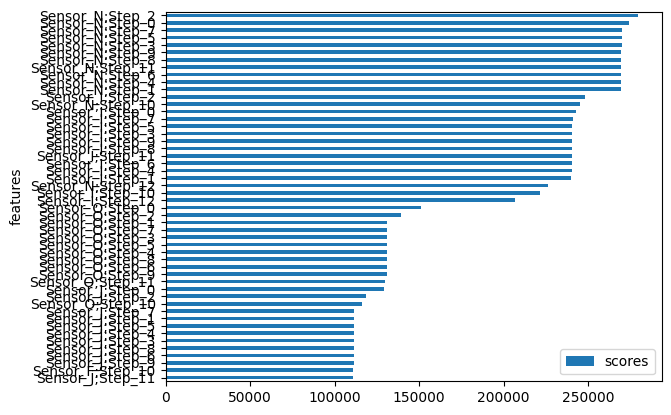

In [ ]:
def select_k_best_regression(X, Y, top_k: int = 50):
    model = SelectKBest(score_func=f_regression, k=top_k)  
    model.fit(X, Y)
    scores = model.scores_
    col_names = X.columns

    score_df = pd.DataFrame({
        'features': col_names,
        'scores': scores
    }).sort_values(by='scores', ascending=False).reset_index(drop=True).round(3)

    selected_features = score_df.head(top_k)['features'].values
    return selected_features, score_df.head(top_k)

# Example usage:
selected_features, top_k_df = select_k_best_regression(X, y, top_k=50)

print("Selected Features:", selected_features)
top_k_df.sort_values(by='scores', ascending=True).plot.barh(y='scores', x='features')

# Data Splitting

In [17]:
# X = final_df[selected_features]
X = final_df[features_to_use]
y = final_df[target]

In [18]:
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2, random_state=42)

print("X train shape:", X_train.shape)
print("y train shape:", y_train.shape)

print("X validate shape:", X_validate.shape)
print("y validate shape:", y_validate.shape)

X train shape: (162288, 526)
y train shape: (162288,)
X validate shape: (40572, 526)
y validate shape: (40572,)


# Model Building and Training

## Models

### 1. Linear Regression

In [19]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validate_scaled = scaler.transform(X_validate)

# Train linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_validate_scaled)

### 2. Extra Trees Regressor

In [ ]:
model_config = {
    'n_estimators': 300,
    'max_depth': 20,
    'criterion': 'squared_error',  # Alternative: 'entropy'
    'random_state': 42,
    'bootstrap':True
}

# Initialize the model with the specified configuration
et_model = ExtraTreesRegressor(**{**model_config})

et_model.fit(X_train, y_train)
y_pred_et = et_model.predict(X_validate)

ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.

In [23]:
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Evaluation:")
    print(f"R² Score: {r2_score(y_true, y_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")

evaluate_model("Linear Regression", y_validate, y_pred_lr)
evaluate_model("Extra Trees Regressor", y_validate, y_pred_et)


Linear Regression Evaluation:
R² Score: 0.7747
RMSE: 0.0803

Extra Trees Regressor Evaluation:
R² Score: 0.9731
RMSE: 0.0277


## Model Initial Evaluation

### Error Distribution Plot

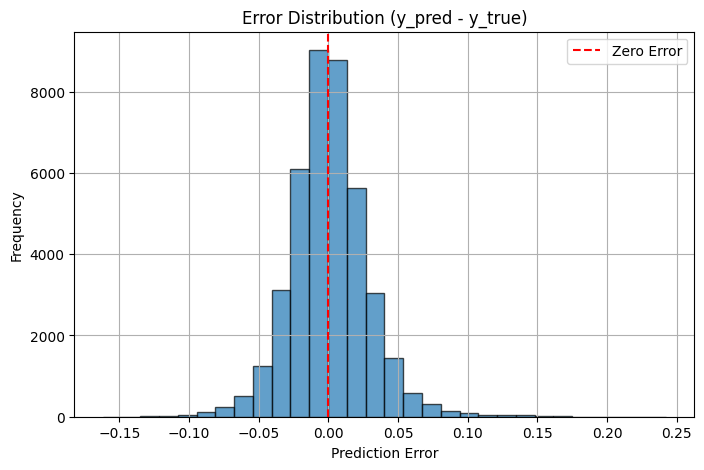

In [27]:
# Assuming you have these:
# y_true = [...]
# y_pred = [...]

errors = y_pred_et - y_validate  # or use abs(y_pred - y_true) for absolute errors

plt.figure(figsize=(8, 5))
plt.hist(errors, bins=30, edgecolor='k', alpha=0.7)
plt.title("Error Distribution (y_pred - y_true)")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.axvline(x=0, color='red', linestyle='--', label='Zero Error')
plt.legend()
plt.grid(True)
plt.show()

### REC Curve (Regression Error Characteristic)

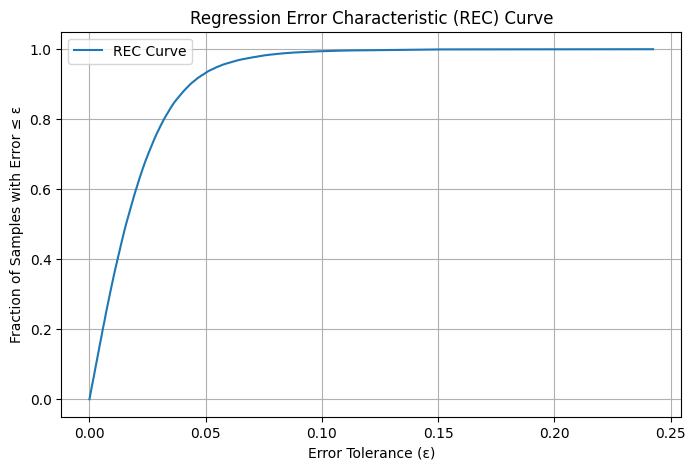

In [28]:
# Compute absolute errors
abs_errors = np.abs(y_pred_et - y_validate)

# Sort errors and define thresholds
sorted_errors = np.sort(abs_errors)
error_thresholds = sorted_errors  # use unique error values as thresholds

# For each threshold, compute the % of points with error ≤ threshold
coverage = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)

# Plot the REC curve
plt.figure(figsize=(8, 5))
plt.plot(error_thresholds, coverage, label='REC Curve')
plt.xlabel("Error Tolerance (ε)")
plt.ylabel("Fraction of Samples with Error ≤ ε")
plt.title("Regression Error Characteristic (REC) Curve")
plt.grid(True)
plt.legend()
plt.show()


# Model Optimisation

## Optuna Tuning

In [ ]:
scorer = make_scorer(mean_squared_error, greater_is_better=False)

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 300)
    max_depth = trial.suggest_int('max_depth', 10, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    model = ExtraTreesRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42,
    )

    score = cross_val_score(model, X_train, y_train, cv=5, scoring=scorer).mean()
    return score

study = optuna.create_study(direction='maximize')  # still maximize because we used negative MSE
study.optimize(objective, n_trials=20)

best_params = study.best_trial.params

print("Best trial:", best_params)

In [ ]:
best_model = ExtraTreesRegressor(
    **best_params,
    random_state=42
)

best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_validate)

evaluate_model("Optimized Extra Trees Regressor", y_validate, y_pred_best)
evaluate_model("Extra Trees Regressor", y_validate, y_pred_et)

In [ ]:
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Model Results on Test Set

## Loading data

In [ ]:
incoming_test_df = pd.read_parquet('test/incoming_run_data.parquet')
incoming_test_df

In [ ]:
run_test_df = pd.read_parquet('test/run_data.parquet')
run_test_df

In [29]:
metrology_test_df = pd.read_parquet('submission/metrology_data.parquet')
metrology_test_df

,Run ID,Run Start Time,Run End Time,X_index,Y_index,X,Y,Point Index,Measurement
0,03aa7486-bf62-5d59-b844-5f2d4a4528c4,2024-01-02 16:31:00,2024-01-02 16:43:35,1,23,-143.877551,-9.183673,3,NaN
1,03aa7486-bf62-5d59-b844-5f2d4a4528c4,2024-01-02 16:31:00,2024-01-02 16:43:35,1,29,-143.877551,27.551020,48,NaN
2,03aa7486-bf62-5d59-b844-5f2d4a4528c4,2024-01-02 16:31:00,2024-01-02 16:43:35,2,34,-137.755102,58.163265,43,NaN
3,03aa7486-bf62-5d59-b844-5f2d4a4528c4,2024-01-02 16:31:00,2024-01-02 16:43:35,3,14,-131.632653,-64.285714,20,NaN
4,03aa7486-bf62-5d59-b844-5f2d4a4528c4,2024-01-02 16:31:00,2024-01-02 16:43:35,5,39,-119.387755,88.775510,8,NaN
...,...,...,...,...,...,...,...,...,...
42135,ef918e33-410b-5687-bb0c-ca086e995572,2024-01-04 01:24:50,2024-01-04 01:37:25,44,11,119.387755,-82.653061,5,NaN
42136,ef918e33-410b-5687-bb0c-ca086e995572,2024-01-04 01:24:50,2024-01-04 01:37:25,44,39,119.387755,88.775510,22,NaN
42137,ef918e33-410b-5687-bb0c-ca086e995572,2024-01-04 01:24:50,2024-01-04 01:37:25,46,26,131.632653,9.183673,46,NaN
42138,ef918e33-410b-5687-bb0c-ca086e995572,2024-01-04 01:24:50,2024-01-04 01:37:25,48,21,143.877551,-21.428571,16,NaN


## Data Processing

In [ ]:
incoming_avg_df_test = average_incoming_data(incoming_test_df)
dataframe_incoming_pivot_test = pivot_incoming_data(incoming_avg_df_test)

run_avg_df_test = average_run_data(run_test_df)
dataframe_run_pivot_test = pivot_run_data(run_avg_df_test)

final_test_df = merge_dataframes(metrology_test_df, dataframe_run_pivot_test, dataframe_incoming_pivot_test)
final_test_df

## Applying Model

In [ ]:
X_test = final_test_df[features_to_use]

y_pred_test = best_model.predict(X_test)

In [ ]:
metrology_test_df['Measurement'] = y_pred_test
metrology_test_df.to_parquet('submission/metrology_data_filled.parquet', index=False)